### 2018/2019 - Task List 10

1. Implement Naive Bayes classifier with pyro
    - create apropriate parameters (mean and std for a and b, sigma - noise)
    - provide optimization procedure
    - check appropriateness of implemented method with selected dataset

In [28]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
import copy
import warnings
from pyro.distributions import Normal, Bernoulli, Categorical, Uniform
from sklearn.model_selection import train_test_split
import warnings
import tensorflow as tf
import math  
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [29]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)
warnings.filterwarnings('ignore')

## Load and analyze data

In [30]:
data = pd.read_csv('iris.txt', sep='\t')
print(data.columns)
# print(torch.from_numpy(data.values[:, 1]))

Index(['SepalLenght', ' SepalWidth', ' PetalLength', ' PetalWidth', 'Label'], dtype='object')


In [31]:
feature1 = data[data.columns[0]]
feature2 = data[data.columns[1]]
feature3 = data[data.columns[2]]
feature4 = data[data.columns[3]]

In [32]:
f1_mean =np.mean(feature1.values)
f1_std = np.std(feature1.values)

f2_mean =np.mean(feature2.values)
f2_std = np.std(feature2.values)

f3_mean =np.mean(feature3.values)
f3_std = np.std(feature3.values)

f4_mean =np.mean(feature4.values)
f4_std = np.std(feature4.values)

print('F1 mean='+str(f1_mean)+', std='+str(f1_std))
print('F2 mean='+str(f2_mean)+', std='+str(f2_std))
print('F3 mean='+str(f3_mean)+', std='+str(f3_std))
print('F4 mean='+str(f4_mean)+', std='+str(f4_std))

F1 mean=5.843333333333334, std=0.8253012917851409
F2 mean=3.0540000000000003, std=0.4321465800705435
F3 mean=3.758666666666666, std=1.7585291834055212
F4 mean=1.1986666666666668, std=0.7606126185881716


In [33]:
X_train, X_test, y_train, y_test =  train_test_split(data, data[data.columns[4]], test_size=0.2)

In [34]:
classes = (0, 1, 2)
lables_num = 3
features_num = 4
count = data.shape[0]

## Naive Bayes sklearn

In [35]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0


## Tests

In [36]:
f0_c0 = data[data.Label == 0]
print(f0_c0.SepalLenght.values.mean())
print(f0_c0.SepalLenght.values.std())


5.006
0.3489469873777391


## Naive Bayes

In [37]:
def predict_label(sample):
    label_probabilities = count_probability_for_each_label(sample)
    the_bigger_prob = label_probabilities[label_probabilities[:, 1] == np.amax(label_probabilities[:, 1])]
    return the_bigger_prob[0, 0]

In [38]:
# result - tablica zawierająza informację o klasie, prawdopodobieństwo
def count_probability_for_each_label(sample):   
    label_probabilities = np.zeros((lables_num, 2))
    posterior_probability  = count_posterior_probability(sample)
    priori_probability = count_prior_probabilities(sample)
    for i in range(lables_num):
        label_probabilities[i, 0] = i
        posterior = 1
        for j in range(features_num):
            posterior = posterior * posterior_probability[i, j]
        #data zmienone na df
        label_probabilities[i, 1] = ((len(df[df.Label == i]) / df.shape[0]) * posterior ) / priori_probability       
    return label_probabilities

In [39]:
# tablica P(x|c) gdzie wiersze = l. klas, kolumny = l. atrybutów
def count_posterior_probability(sample):
    p_x_c = np.empty((lables_num, features_num))
    for i in range(lables_num):
        for j in range(features_num):
            p_x_c[i, j] = count_density_probability(sample[j], mi_result[i, j],  sigma_result[i, j])

          #  p_x_c[i, j] = count_density_probability(sample[j], pyro.param("mi_{}_{}".format(i, j)), pyro.param("sigma_{}_{}".format(i, j)))
    return p_x_c      

In [40]:
# P(f1)* .. *P(fn)
def count_prior_probabilities(sample):
    return count_density_probability(sample[0], f1_mean, f1_std) * count_density_probability(sample[1], f2_mean, f2_std)  * count_density_probability(sample[2], f3_mean, f3_std) * count_density_probability(sample[3], f4_mean, f4_std)

In [105]:
def count_density_probability(value, mean, std):
    p =(1 / math.sqrt(2*std*math.pi)) * math.pow(math.e, (-1)* (math.pow(value - mean,2) / 2*math.pow(std,2)))
    return p

## Train model

In [42]:
x_c = np.empty((lables_num, features_num))

mi = np.empty((lables_num, features_num))
sigma = np.empty((lables_num, features_num))

In [43]:
noise = 0.5
def model(data): 
    for i in range(lables_num):
        for j in range(features_num):
            x_c[i, j] = pyro.sample('sample_'+str(i)+'_'+str(j) , Normal(0., 1.))
            
    for i in range(len(classes)):
        sub_data = data[data.Label == classes[i]]
        for k in range(features_num):
            with pyro.plate('data_{}_{}'.format(i, k), len(sub_data)):
                data_obs = torch.from_numpy(sub_data.values[:, k].astype(np.float)).type(torch.FloatTensor) 
                pyro.sample("obs_{}_{}".format(i,  k), Normal(x_c[i, k],  noise) , obs = data_obs)             

In [44]:
def guide(data):   
    for i in range(lables_num):
        for j in range(features_num):
            pyro.param('mi_'+str(i)+'_'+str(j), torch.tensor(5.))
    
    for i in range(lables_num):
        for j in range(features_num): 
            pyro.param('sigma_'+str(i)+'_'+str(j), torch.tensor(0.3), constraint=constraints.positive)
            
    for i in range(lables_num):
        for j in range(features_num):          
            x_c[i, j] = pyro.sample('sample_'+str(i)+'_'+str(j) , Normal(pyro.param('mi_'+str(i)+'_'+str(j)), pyro.param('sigma_'+str(i)+'_'+str(j))))   

In [45]:
def train():
    pyro.clear_param_store()
    num_iterations=100
    optim = pyro.optim.Adam({"lr": 0.03})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    losses = []
    for j in range(num_iterations):
        loss = svi.step(data)
        losses.append(loss)
    return (svi, losses)

In [46]:
svi, loss = train()
posterior = svi.run(X_train)
for i in range(lables_num):
    for j in range(features_num):
        print('mi:')
        print(pyro.param("mi_{}_{}".format(i, j)))



mi:
tensor(2.3589, requires_grad=True)
mi:
tensor(2.3874, requires_grad=True)
mi:
tensor(2.3966, requires_grad=True)
mi:
tensor(2.4170, requires_grad=True)
mi:
tensor(2.3610, requires_grad=True)
mi:
tensor(2.3537, requires_grad=True)
mi:
tensor(2.3348, requires_grad=True)
mi:
tensor(2.3844, requires_grad=True)
mi:
tensor(2.4160, requires_grad=True)
mi:
tensor(2.3658, requires_grad=True)
mi:
tensor(2.3932, requires_grad=True)
mi:
tensor(2.3988, requires_grad=True)


## Predict samples

In [47]:
y_true, y_pred = [], []
for i in range(len(X_test)):
    y_true.append(X_test.values[i, 4])
    y_pred.append(predict_label(X_test.values[i]))
print(y_true)
print(y_pred)

NameError: name 'mi_result' is not defined

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

## Second approach

In [192]:
df = pd.read_csv('iris.txt', sep='\t')
X_train, X_test, y_train, y_test =  train_test_split(df, df[df.columns[4]], test_size=0.2)

In [193]:
mi_result = np.empty((lables_num, features_num))
sigma_result = np.empty((lables_num, features_num))

In [194]:
def model3(data): 
    
    mi = pyro.sample('mi' , Normal(0., 1.))   
    sigma = pyro.sample('sigma' , Uniform(0., 10.))    
    with pyro.plate('data', len(data)):
        data_obs = torch.from_numpy(data.values.astype(np.float)).type(torch.FloatTensor) 
        pyro.sample("obs", Normal(mi,  sigma) , obs = data_obs)    
        
#     x = pyro.sample('sample' , Normal(0., 1.))   
#     with pyro.plate('data', len(data)):
#         data_obs = torch.from_numpy(data.values.astype(np.float)).type(torch.FloatTensor) 
#         pyro.sample("obs", Normal(x,  1.5) , obs = data_obs)    

In [195]:
def guide3(data):  
    mi_loc =pyro.param('mi_loc', torch.tensor(1.))
    mi_scale = pyro.param('mi_scale', torch.tensor(0.3), constraint=constraints.positive)  
    
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),  constraint=constraints.positive) 
    
    mi = pyro.sample('mi', Normal(mi_loc, mi_scale))
    sigma = pyro.sample('sigma', Normal(sigma_loc, torch.tensor(0.05)))
#     mi =  pyro.param('mi', torch.tensor(1.))
#     sigma = pyro.param('sigma', torch.tensor(0.3), constraint=constraints.positive)  
#     x = pyro.sample('sample' , Normal(mi, sigma))   

In [196]:
def train3(data):
    pyro.clear_param_store()
    num_iterations= 3000
    optim = pyro.optim.Adam({"lr": 0.03})
    svi = pyro.infer.SVI(model3, guide3, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    losses = []
    for j in range(num_iterations):
        loss = svi.step(data)
        losses.append(loss)
    return (svi, losses)

In [197]:
for i in range(lables_num):
    for j in range(features_num):
        data = X_train[X_train.Label == i]
        data =  data[data.columns[j]]
        svi, loss = train3(data)
        posterior = svi.run(data)        
        mi_result[i, j] = pyro.param("mi_loc").item()
        sigma_result[i, j] = pyro.param("sigma_loc").item()
        print(pyro.param("mi_loc"))
        print(pyro.param("sigma_loc"))
 

tensor(4.9501, requires_grad=True)
tensor(0.4271, grad_fn=<AddBackward0>)


tensor(3.3430, requires_grad=True)
tensor(0.4029, grad_fn=<AddBackward0>)


tensor(1.7116, requires_grad=True)
tensor(0.3980, grad_fn=<AddBackward0>)


tensor(0.2488, requires_grad=True)
tensor(0.1545, grad_fn=<AddBackward0>)


tensor(5.9330, requires_grad=True)
tensor(0.4826, grad_fn=<AddBackward0>)


tensor(2.7726, requires_grad=True)
tensor(0.3178, grad_fn=<AddBackward0>)


tensor(4.3105, requires_grad=True)
tensor(0.4603, grad_fn=<AddBackward0>)


tensor(1.3572, requires_grad=True)
tensor(0.2177, grad_fn=<AddBackward0>)


tensor(6.4602, requires_grad=True)
tensor(0.6523, grad_fn=<AddBackward0>)


tensor(3.0100, requires_grad=True)
tensor(0.3523, grad_fn=<AddBackward0>)


tensor(5.4445, requires_grad=True)
tensor(0.5488, grad_fn=<AddBackward0>)


tensor(2.0444, requires_grad=True)
tensor(0.3622, grad_fn=<AddBackward0>)


In [198]:
y_true, y_pred = [], []
for i in range(len(X_test)):
    y_true.append(X_test.values[i, 4])
    y_pred.append(predict_label(X_test.values[i]))
print(y_true)
print(y_pred)

[0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 2.0]
[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]


In [201]:
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

0.6333333333333333


## Real data

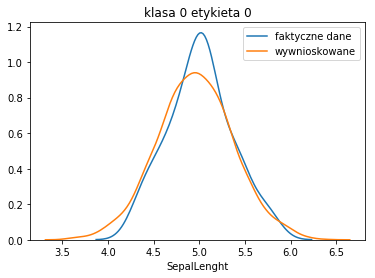

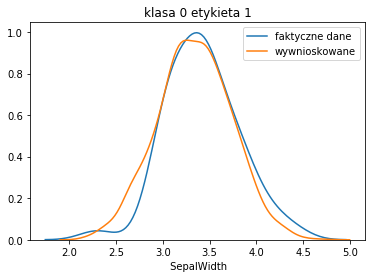

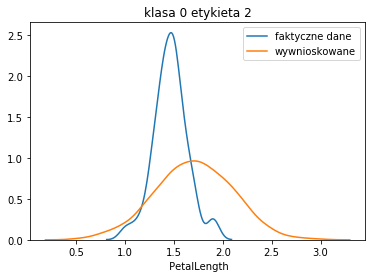

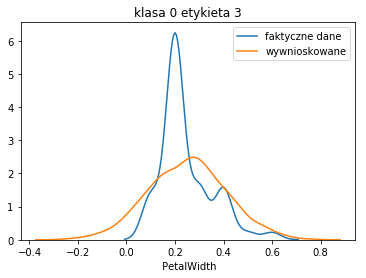

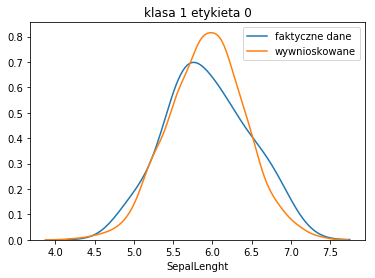

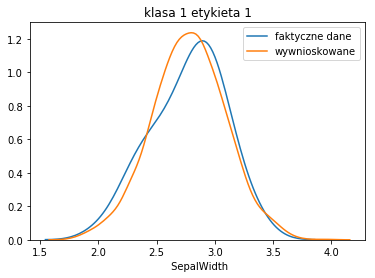

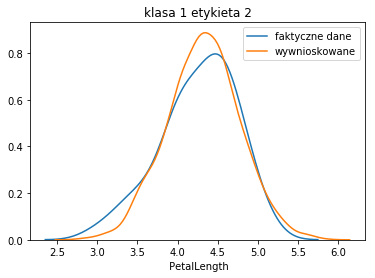

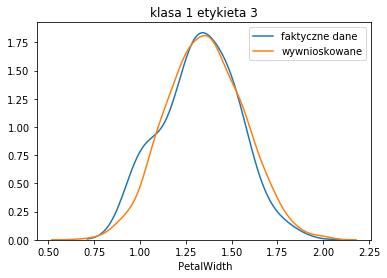

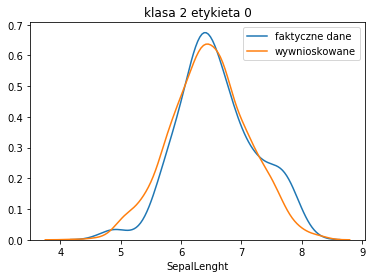

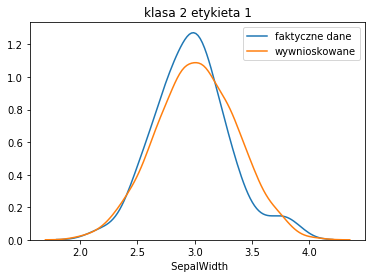

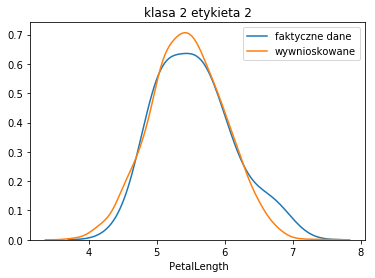

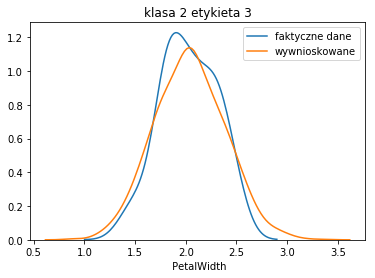

In [202]:
for i in range(lables_num):
    for j in range(features_num):
        data1 = df[df.Label == i]
        data1 =  data1[data1.columns[j]]

        data_distr = Normal(mi_result[i, j], torch.Tensor(2000*[ sigma_result[i, j]]))
        sampled_data = data_distr.sample()
        data2 = sampled_data.data.numpy()
        sns.distplot(data1, hist = False,  label='faktyczne dane')   
        sns.distplot(data2, hist=  False, label = 'wywnioskowane') 
        plt.title('klasa '+str(i)+ ' etykieta '+ str(j))
        plt.legend()
        plt.show()
        plt.close()